# Image Segmentation
### This Notebook demonstrates how the CelebAMask dataset can be used to fuse a hairstyle on to a different person
##### https://github.com/switchablenorms/CelebAMask-HQ
I created a smaller folder containing just 30 images and and a folder containg its corresponding masks

In [3]:
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import math

In [3]:
blacklist_hairstyle= [1486]

In [4]:
with open('../CelebAMask-HQ/CelebAMask-HQ-attribute-anno.txt') as f:
    lines = f.readlines()
    

In [5]:
columns = ['image_name','drop','5_o_Clock_Shadow','Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs',
           'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
           'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
           'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
           'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 
           'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
attributes = pd.read_csv('../CelebAMask-HQ/CelebAMask-HQ-attribute-anno.txt',skiprows=[0,1], sep=' ',names= columns, header=None)
attributes.drop('drop', axis=1,inplace=True)
attributes

,image_name,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0.jpg,-1,1,1,1,-1,-1,1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
1,1.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
2,2.jpg,-1,-1,1,1,-1,-1,1,-1,-1,...,-1,1,-1,1,1,-1,1,-1,-1,1
3,3.jpg,-1,-1,1,-1,-1,-1,-1,1,1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
4,4.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995.jpg,-1,-1,-1,-1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,1,-1,-1
29996,29996.jpg,1,-1,-1,1,-1,-1,-1,1,-1,...,1,1,-1,-1,-1,-1,-1,-1,-1,1
29997,29997.jpg,-1,-1,-1,-1,-1,1,-1,-1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
29998,29998.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1


In [6]:
attributes['Wearing_Hat'].value_counts()

-1    28930
 1     1070
Name: Wearing_Hat, dtype: int64

### Get all faces that look straight at the camera

### fuse pose and image attributes

In [7]:
columns = ['image_name','Yaw','Pitch','Raw']
pose = pd.read_csv('../CelebAMask-HQ/CelebAMask-HQ-pose-anno.txt',skiprows=[0,1], sep=' ',names= columns, header=None)
#pose.drop('drop', axis=1,inplace=True)
pose[pose["Yaw"]<abs(5)]
data_straight = pose[(abs(pose['Yaw']) < 5) & (abs(pose['Pitch']) < 5) & (abs(pose['Raw']) < 5)]
data_straight
#plt.scatter(pose["Yaw"],pose["Pitch"])

,image_name,Yaw,Pitch,Raw
15,15.jpg,4.738663,-4.512314,-0.144493
31,31.jpg,2.470963,2.043396,-0.192787
35,35.jpg,-0.353325,-1.079887,1.445816
57,57.jpg,0.090805,-1.680588,1.779587
76,76.jpg,2.466019,-1.397171,1.315727
...,...,...,...,...
29967,29967.jpg,4.066154,0.663956,-1.773636
29970,29970.jpg,4.294647,-2.834167,-0.480446
29982,29982.jpg,2.493683,-0.397705,-0.297386
29995,29995.jpg,0.108932,-0.664413,0.135849


In [8]:
data_all  = pd.concat([pose, attributes.drop('image_name', axis=1)], axis=1)
data_all

,image_name,Yaw,Pitch,Raw,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0.jpg,-16.761650,-3.540695,-0.468292,-1,1,1,1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
1,1.jpg,8.853630,-16.055931,-1.150886,-1,1,1,-1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
2,2.jpg,35.265182,-6.890411,-1.581253,-1,-1,1,1,-1,-1,...,-1,1,-1,1,1,-1,1,-1,-1,1
3,3.jpg,-16.793152,1.010948,0.133667,-1,-1,1,-1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
4,4.jpg,5.474228,-12.340668,-0.894409,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995.jpg,0.108932,-0.664413,0.135849,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,1,-1,-1
29996,29996.jpg,4.065002,-1.689423,-1.262672,1,-1,-1,1,-1,-1,...,1,1,-1,-1,-1,-1,-1,-1,-1,1
29997,29997.jpg,5.378021,-12.933311,1.843475,-1,-1,-1,-1,-1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
29998,29998.jpg,16.967903,-6.059593,-3.954010,-1,1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1


#### Remove hats etc.

In [9]:
data_nohat=data_all[data_all["Wearing_Hat"]==-1]
data_nohat

,image_name,Yaw,Pitch,Raw,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0.jpg,-16.761650,-3.540695,-0.468292,-1,1,1,1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
1,1.jpg,8.853630,-16.055931,-1.150886,-1,1,1,-1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
2,2.jpg,35.265182,-6.890411,-1.581253,-1,-1,1,1,-1,-1,...,-1,1,-1,1,1,-1,1,-1,-1,1
3,3.jpg,-16.793152,1.010948,0.133667,-1,-1,1,-1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
4,4.jpg,5.474228,-12.340668,-0.894409,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,-1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995.jpg,0.108932,-0.664413,0.135849,-1,-1,-1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,1,-1,-1
29996,29996.jpg,4.065002,-1.689423,-1.262672,1,-1,-1,1,-1,-1,...,1,1,-1,-1,-1,-1,-1,-1,-1,1
29997,29997.jpg,5.378021,-12.933311,1.843475,-1,-1,-1,-1,-1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
29998,29998.jpg,16.967903,-6.059593,-3.954010,-1,1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,1,-1,-1,1


No hat + Straight + Feale

In [10]:
dataset1=data_all[(abs(data_all['Yaw']) < 5) & 
                     (abs(data_all['Pitch']) < 5) & 
                     (abs(data_all['Raw']) < 5) &
                     (data_all["Wearing_Hat"] == -1) &
                     (data_all["Male"] == 1)&
                     (data_all["Attractive"]== 1)]
dataset1

,image_name,Yaw,Pitch,Raw,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
264,264.jpg,-3.438927,-2.365791,-0.218384,1,-1,1,-1,-1,1,...,-1,-1,1,-1,-1,-1,-1,-1,-1,1
317,317.jpg,3.630768,-3.403198,-0.472435,1,1,1,-1,-1,1,...,1,1,-1,1,-1,-1,-1,-1,-1,1
554,554.jpg,-3.718903,-1.926529,0.410110,1,-1,1,-1,-1,1,...,-1,-1,-1,1,-1,-1,-1,-1,1,1
588,588.jpg,2.448639,-4.824760,0.278481,1,-1,1,1,-1,-1,...,1,1,-1,-1,-1,-1,-1,-1,-1,1
823,823.jpg,1.358505,-2.983597,0.495346,1,-1,1,1,-1,-1,...,1,-1,-1,-1,-1,-1,-1,-1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29712,29712.jpg,1.063156,-0.012016,-0.576096,1,-1,1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,1,1
29735,29735.jpg,1.356140,-1.614380,-0.266212,1,-1,1,-1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
29820,29820.jpg,1.634537,0.163406,0.520355,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,1
29848,29848.jpg,-2.594124,-1.403061,0.236252,1,-1,1,1,-1,-1,...,-1,1,1,-1,-1,-1,-1,-1,-1,1


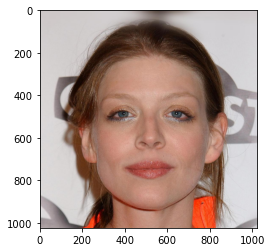

In [11]:
i = 322
# load style image
path_style = '../CelebAMask-HQ/CelebA-HQ-img/'+str(i)+'.jpg'

image_style = cv2.imread(path_style)
image_style = cv2.cvtColor(image_style, cv2.COLOR_RGB2BGR)

plt.imshow(image_style)


Get all the features that are available in the dataset

In [12]:
from os import listdir
from os.path import isfile, join
filenames = [f for f in listdir('../CelebAMask-HQ/CelebAMask-HQ-mask-anno/0') if isfile(join('../CelebAMask-HQ/CelebAMask-HQ-mask-anno/0', f))]
features = set([w[5:] for w in filenames])
print(features)

{'_l_eye.png', '_eye_g.png', '_neck.png', '_hair.png', '_u_lip.png', '_ear_r.png', '_hat.png', '_l_ear.png', '_cloth.png', '_l_lip.png', '_r_ear.png', '_skin.png', '_r_brow.png', '_neck_l.png', '_nose.png', '_r_eye.png', '_l_brow.png', '_mouth.png'}


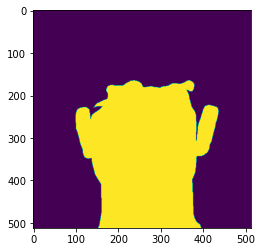

In [13]:
masks = {
         '_l_brow.png', '_l_lip.png', '_mouth.png', '_nose.png', 
         '_r_eye.png', '_r_brow.png',
         '_u_lip.png', '_l_eye.png', 
         '_r_ear.png', '_l_ear.png', #ears
         #'_ear_r.png', # earrings
         '_neck_l.png', # necklace
         #'_hat.png', # hat
         '_neck.png' # neck
         #'_hair.png', # hair
         #'_cloth.png', # clothes
         #'_eye_g.png' # glasses
         #'_skin.png',
        }
i = 322
i=317
path_mask = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/'+str(i).zfill(5)+'_skin.png'
if os.path.isfile(path_mask):
    mask_total = cv2.imread(path_mask,0)
for feature in masks:
    path_mask = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/'+str(i).zfill(5)+feature
    if os.path.isfile(path_mask):
        mask_add = cv2.imread(path_mask,0)
    mask_total = cv2.add(mask_total,mask_add)
mask=np.where(mask_total == 0, mask_total, 255)
plt.imshow(mask)


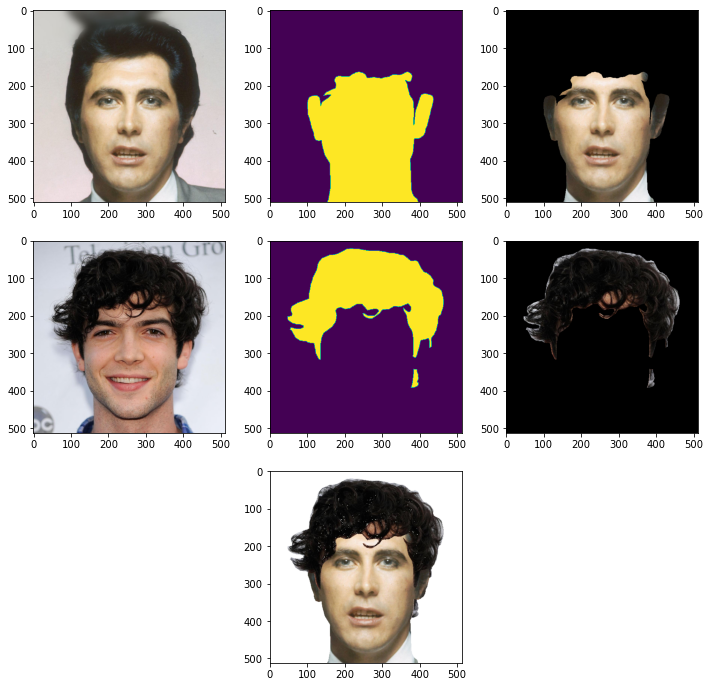

In [14]:
i= 322
i=281
path_upload = '../CelebAMask-HQ/CelebA-HQ-img/'+str(i)+'.jpg'

image_upload = cv2.imread(path_upload)
image_upload = cv2.cvtColor(image_upload, cv2.COLOR_RGB2BGR)
image_upload = cv2.resize(image_upload, (0,0), fx=0.5, fy=0.5)

j = 35
j=317
# load 'uploaded' image
path_stlye = '../CelebAMask-HQ/CelebA-HQ-img/'+str(j)+'.jpg'
image = cv2.imread(path_stlye)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image = cv2.resize(image, (0,0), fx=0.5, fy=0.5) 
# load mask hair
path_mask = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/'+str(j).zfill(5)+'_hair.png'
mask_style = cv2.imread(path_mask,0)

fig, axs = plt.subplots(3, 3,figsize=(12,12))
fig.delaxes(axs[2,0])
fig.delaxes(axs[2,2])

face = cv2.bitwise_and(image_upload,image_upload,mask = mask)
style = cv2.bitwise_and(image,image,mask = mask_style)

# combine the two masked images
face_minus = cv2.bitwise_and(face, face, mask=255-mask_style)
result = cv2.add(style, face_minus)
result[result[:,:,2]==0]=255


axs[0,0].imshow(image_upload)
axs[0,1].imshow(mask)
axs[0,2].imshow(face)
axs[1,0].imshow(image)
axs[1,1].imshow(mask_style)
axs[1,2].imshow(style)
axs[2,1].imshow(result)


### Get hairstyle that are not cropped

/var/folders/f2/nn54q4ts3cz78hjvdr674n980000gn/T/ipykernel_12736/157230733.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 2,figsize=(4,4))


(82, 512, 512, 3)

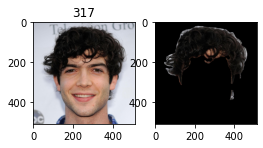

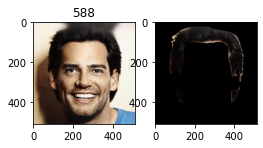

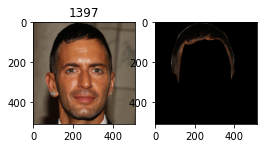

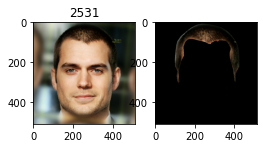

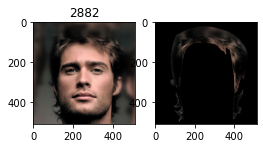

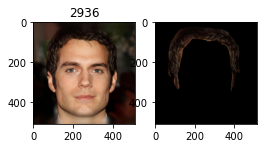

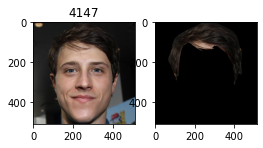

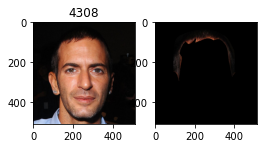

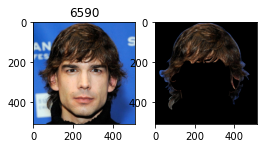

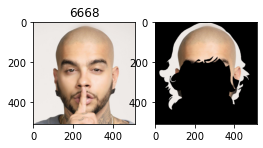

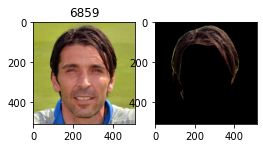

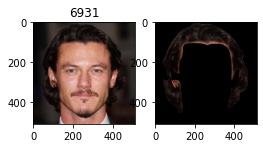

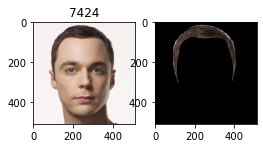

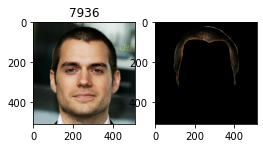

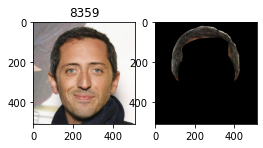

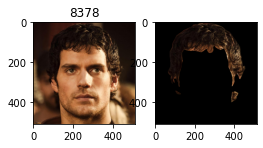

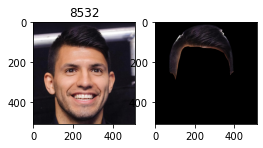

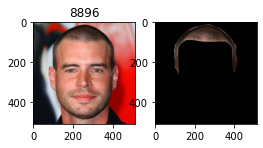

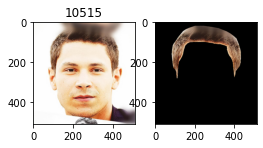

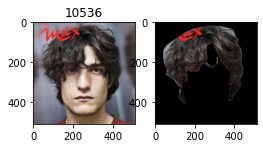

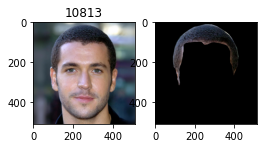

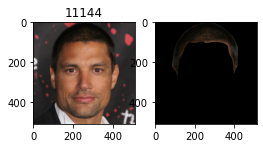

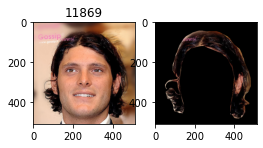

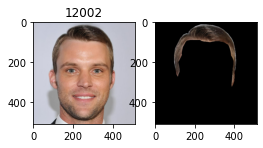

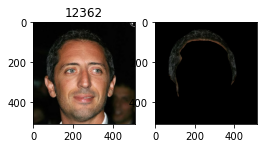

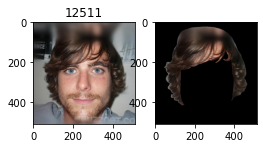

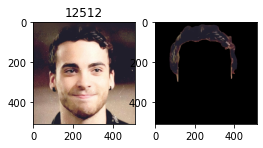

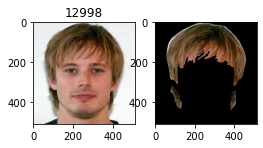

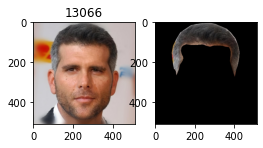

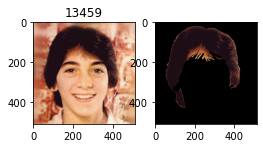

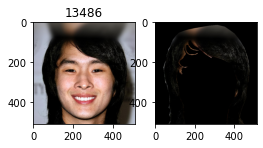

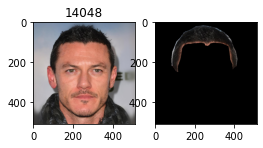

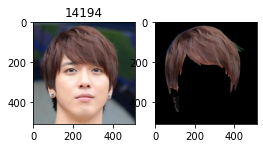

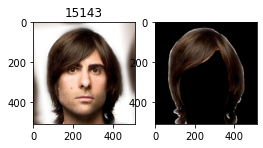

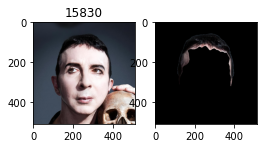

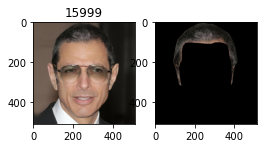

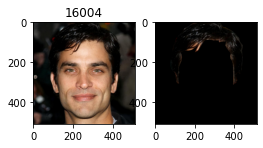

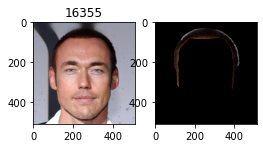

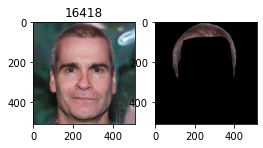

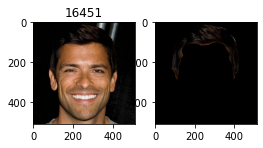

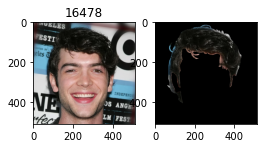

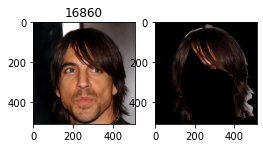

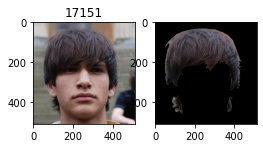

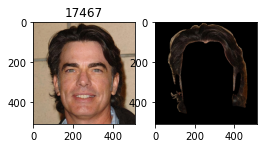

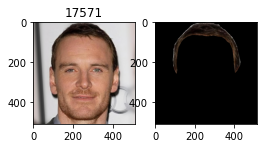

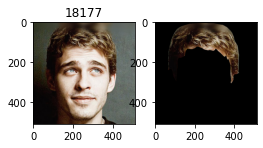

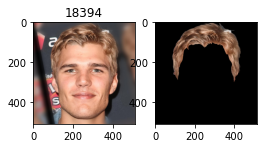

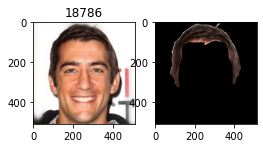

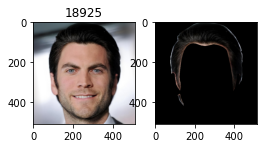

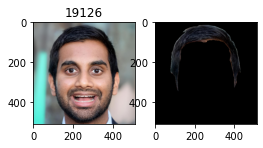

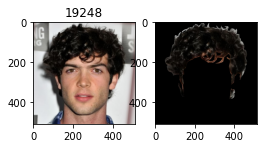

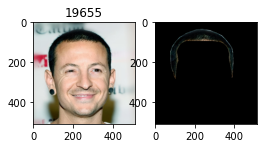

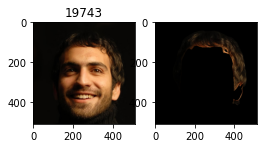

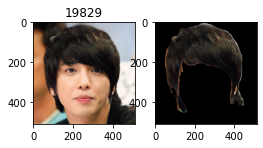

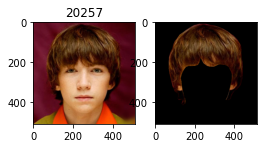

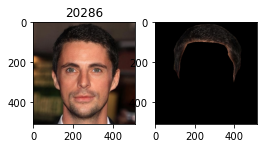

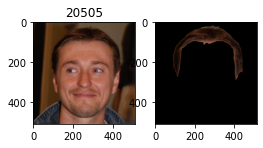

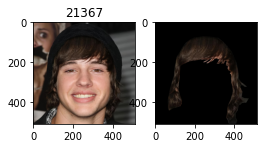

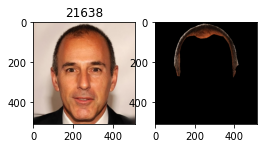

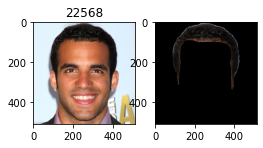

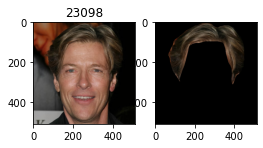

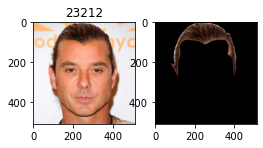

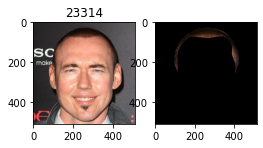

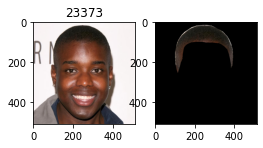

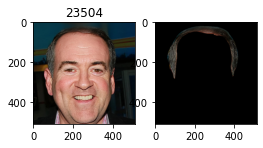

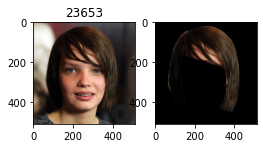

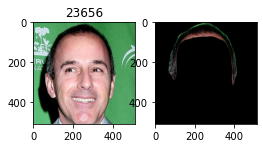

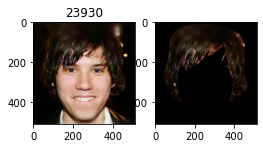

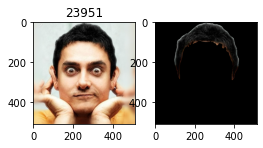

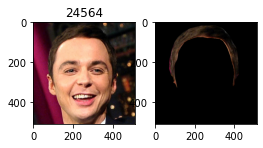

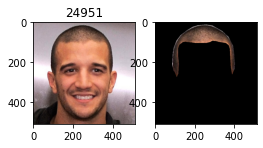

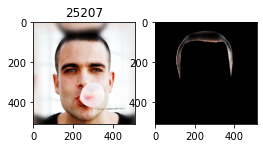

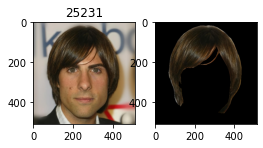

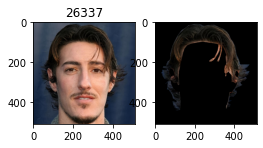

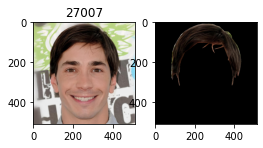

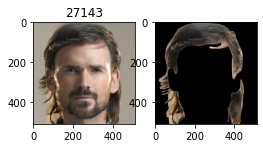

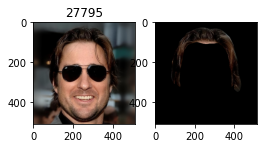

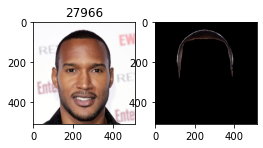

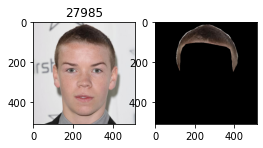

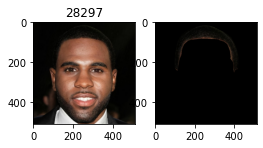

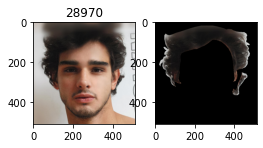

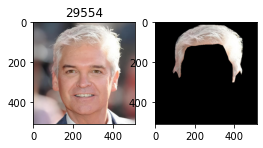

In [15]:
non_cropped = []
hairstyles = []
for i in dataset1.index:
    j = math.trunc(i/2000)
    hair_mask = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/'+str(j)+'/'+str(i).zfill(5)+'_hair.png'
    if os.path.isfile(hair_mask):
        mask = cv2.imread(hair_mask,0)
        is_all_zero_up = np.all((mask[0,:] == 0))
        is_all_zero_left = np.all((mask[:,0] == 0))
        is_all_zero_right = np.all((mask[:,-1] == 0))
        
    if is_all_zero_up & is_all_zero_left & is_all_zero_right:
        path = '../CelebAMask-HQ/CelebA-HQ-img/'+str(i)+'.jpg'
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        image = cv2.resize(image, (0,0), fx=0.5, fy=0.5) 

        hairstyle = cv2.bitwise_and(image,image,mask = mask)
        
        fig, axs = plt.subplots(1, 2,figsize=(4,4))
        axs[0].title.set_text(i)
        axs[0].imshow(image)
        axs[1].imshow(hairstyle)
        non_cropped.append(i)
        hairstyles.append(hairstyle)
        
hairstyles = np.array(hairstyles)
        
#img_num = 400


#test_X = X.flatten('F').reshape((img_num,-1),order='F')
#print("flatten done")
#print(test_X.shape)
#np.save('data_X.npy', test_X)
#print("save as .npy done")        
hairstyles.shape
#print(non_cropped)



### Train neural networks

### get skin mask

In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from pandas.io.parsers import read_csv
from skimage.color import rgb2gray
from tensorflow import keras 

In [5]:
#Load masks
indx = []
y = []
for i in range(800):
    masks = {
         #'_l_brow.png', '_l_lip.png', '_mouth.png', '_nose.png', 
         #'_r_eye.png', '_r_brow.png',
         #'_u_lip.png', '_l_eye.png', 
         #'_r_ear.png', '_l_ear.png', #ears
         #'_ear_r.png', # earrings
         #'_neck_l.png', # necklace
         #'_hat.png', # hat
         #'_neck.png' # neck
         #'_hair.png', # hair
         #'_cloth.png', # clothes
         #'_eye_g.png' # glasses
         '_skin.png',
        }
    indx.append(i)
    mask_total=[]
    path_mask = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/'+str(i).zfill(5)+'_skin.png'
    if os.path.isfile(path_mask):
            mask_total = cv2.imread(path_mask)
            mask_total = cv2.resize(mask_total, (128,128))

    for feature in masks:
        path_mask = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/'+str(i).zfill(5)+feature
        if os.path.isfile(path_mask):
            mask_add = cv2.imread(path_mask)
            mask_add = cv2.resize(mask_add, (128,128))

        mask_total = cv2.add(mask_total,mask_add)
        mask=np.where(mask_total == 0, mask_total, 255)
        mask =   rgb2gray(mask)
    #mask = mask.flatten()
    y.append(mask)

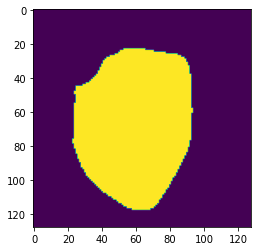

In [6]:
#maskEx = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
#maskEx = cv2.resize(maskEx, (96,96))
plt.figure(figsize=(4,4))
plt.imshow(y[56])
plt.show()


In [7]:
#Load Images
X = []
for i in range(len(indx)):
    path_image = '../CelebAMask-HQ/CelebA-HQ-img/'+str(indx[i])+'.jpg'
    img = cv2.imread(path_image,0)
    #img = rgb2gray(img)
    img = cv2.resize(img, (128,128))
    #img = img.flatten()
    X.append(img)

In [8]:
print(np.array(X).shape)
print(np.array(y).shape)
X = np.array(X)
y = np.array(y)

(800, 128, 128)
(800, 128, 128)


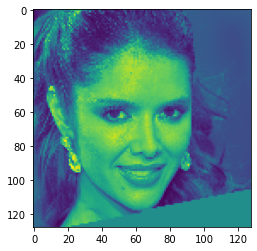

In [9]:
plt.imshow(X[56])


### Save and load of image array as npy file in order to use in collab

In [ ]:
#number of images to be saved
img_num = 400


test_X = X.flatten('F').reshape((img_num,-1),order='F')
print("flatten done")
print(test_X.shape)
np.save('data_X.npy', test_X)
print("save as .npy done")
test_X = np.load('data_X.npy')
print("load csv done")
test_X = test_X.reshape((img_num,512,512,3), order='F')
print("reshaping done")

print(test_X.shape)

In [ ]:
test_y = y.flatten('F').reshape((img_num,-1),order='F')
print("flatten done")
print(test_y.shape)
np.save('data_y.npy', test_y)
print("save as .npy done")
test_y = np.load('data_y.npy')
print("load csv done")
test_y = test_y.reshape((img_num,512,512), order='F')
print("reshaping done")

print(test_y.shape)


### Train face segementation model

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
#X_train = np.expand_dims(X_train, -1)

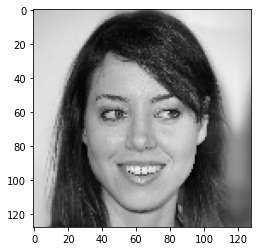

In [11]:
#maskEx = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
#maskEx = cv2.resize(maskEx, (96,96))
plt.figure(figsize=(4,4))
plt.imshow(X_train[9],cmap="gray")
plt.show()


In [12]:
import tensorflow as tf

In [13]:
def unet(input_size = (128,128,1)):
    inputs = tf.keras.layers.Input(input_size)
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [14]:
model=unet(input_size=(128,128,1))

2021-11-25 15:30:46.031766: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
from tensorflow.keras.optimizers import Adam 
#from keras.callbacks import EarlyStopping
optimizer_adam = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.99)

In [16]:
model.compile(optimizer=optimizer_adam,loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
history=model.fit(X_train, y_train, epochs=100,batch_size=30, verbose=1)

2021-11-25 15:30:46.307007: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
19/19 [==============================] - 27s 1s/step - loss: 0.6003 - accuracy: 0.6834
Epoch 2/100
19/19 [==============================] - 25s 1s/step - loss: 0.3330 - accuracy: 0.8388
Epoch 3/100
19/19 [==============================] - 26s 1s/step - loss: 0.2316 - accuracy: 0.9188
Epoch 4/100
19/19 [==============================] - 26s 1s/step - loss: 0.1881 - accuracy: 0.9302
Epoch 5/100
19/19 [==============================] - 26s 1s/step - loss: 0.1797 - accuracy: 0.9318
Epoch 6/100
19/19 [==============================] - 25s 1s/step - loss: 0.1700 - accuracy: 0.9351
Epoch 7/100
19/19 [==============================] - 25s 1s/step - loss: 0.1513 - accuracy: 0.9410
Epoch 8/100
19/19 [==============================] - 26s 1s/step - loss: 0.1466 - accuracy: 0.9430
Epoch 9/100
19/19 [==============================] - 25s 1s/step - loss: 0.1279 - accuracy: 0.9499
Epoch 10/100
19/19 [==============================] - 25s 1s/step - loss: 0.1230 - accuracy: 0.9524
Epoch 11/

19/19 [==============================] - 26s 1s/step - loss: 0.0197 - accuracy: 0.9915
Epoch 84/100
19/19 [==============================] - 26s 1s/step - loss: 0.0199 - accuracy: 0.9915
Epoch 85/100
19/19 [==============================] - 26s 1s/step - loss: 0.0197 - accuracy: 0.9916
Epoch 86/100
19/19 [==============================] - 25s 1s/step - loss: 0.0190 - accuracy: 0.9919
Epoch 87/100
19/19 [==============================] - 25s 1s/step - loss: 0.0242 - accuracy: 0.9901
Epoch 88/100
19/19 [==============================] - 25s 1s/step - loss: 0.0256 - accuracy: 0.9893
Epoch 89/100
19/19 [==============================] - 25s 1s/step - loss: 0.0219 - accuracy: 0.9906
Epoch 90/100
19/19 [==============================] - 25s 1s/step - loss: 0.0198 - accuracy: 0.9915
Epoch 91/100
19/19 [==============================] - 25s 1s/step - loss: 0.0183 - accuracy: 0.9921
Epoch 92/100
19/19 [==============================] - 25s 1s/step - loss: 0.0174 - accuracy: 0.9925
Epoch 93/100


In [18]:
y_pred=model.predict(X_test)

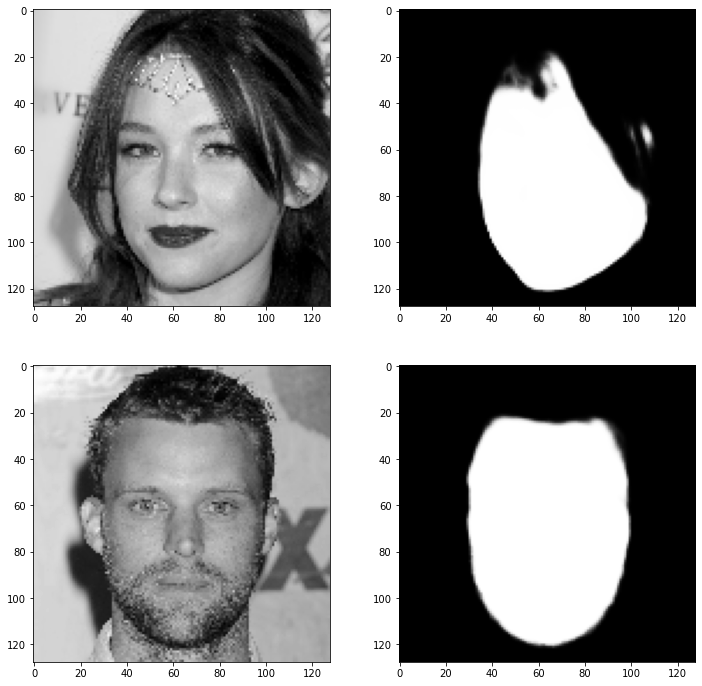

In [23]:
fig, axs = plt.subplots(2, 2,figsize=(12,12))
X_testProva = cv2.cvtColor(X_test[30],cv2.COLOR_BGR2RGB)
y_predProva = cv2.cvtColor(y_pred[30],cv2.COLOR_BGR2RGB)
axs[0,0].imshow(X_testProva)
axs[0,1].imshow(y_predProva)
axs[1,0].imshow(X_test[31],cmap="gray")
axs[1,1].imshow(y_pred[31],cmap="gray")

In [24]:
model.save('unetmodeltrained_low_resolution128noneck')


2021-11-25 16:27:52.204516: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: unetmodeltrained_low_resolution128noneck/assets


In [ ]:
# load model for rgb
#model = keras.models.load_model('unetmodeltrained')


### Example 

In [82]:
X = []

path= 'unnamed.jpg'
image = cv2.imread(path,0)
image = image[120:120+420, 100:100+420]
image = cv2.resize(image, (128,128),interpolation = cv2.INTER_AREA)
X.append(image)
X.append(image)

X = np.array(X)
X.shape
y_pred=model.predict(X)

In [85]:
path= 'unnamed.jpg'
image = cv2.imread(path,0)
image = image[120:120+420, 100:100+420]

fig, axs = plt.subplots(2, 2,figsize=(12,12))

axs[0,0].imshow(image)
axs[0,1].imshow(y_pred[0])


NameError: name 'l' is not defined

In [ ]:
plt.imshow(image)

In [ ]:
X = np.array(X)
X.shape

In [ ]:
y_pred=model.predict(X)

In [ ]:

#axs[1,0].imshow(X)
plt.imshow(y_pred[0])

### pose detection model


In [ ]:
### Script dummy 

In [ ]:
masks = {
         '_l_brow.png', '_l_lip.png', '_mouth.png', '_nose.png', 
         '_r_eye.png', '_r_brow.png',
         '_u_lip.png', '_l_eye.png', 
         '_r_ear.png', '_l_ear.png', #ears
         #'_ear_r.png', # earrings
         '_neck_l.png', # necklace
         #'_hat.png', # hat
         '_neck.png' # neck
         #'_hair.png', # hair
         #'_cloth.png', # clothes
         #'_eye_g.png' # glasses
         #'_skin.png',
        }
i = 322
i=317
path_mask = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/'+str(i).zfill(5)+'_skin.png'
if os.path.isfile(path_mask):
    mask_total = cv2.imread(path_mask,0)
for feature in masks:
    path_mask = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/'+str(i).zfill(5)+feature
    if os.path.isfile(path_mask):
        mask_add = cv2.imread(path_mask,0)
    mask_total = cv2.add(mask_total,mask_add)
mask=np.where(mask_total == 0, mask_total, 255)
plt.imshow(mask)


In [64]:
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import math


# load hairstyle images 
path_style1 = '../CelebAMask-HQ/CelebA-HQ-img/'+str(6859)+'.jpg'
path_style2 = '../CelebAMask-HQ/CelebA-HQ-img/'+str(317)+'.jpg'
path_style3 = '../CelebAMask-HQ/CelebA-HQ-img/'+str(18394)+'.jpg'

image_style1 = cv2.imread(path_style1)
#image_style1 = cv2.cvtColor(image_style1, cv2.COLOR_RGB2BGR)
image_style1 = cv2.resize(image_style1, (0,0), fx=0.5, fy=0.5)

image_style2 = cv2.imread(path_style2)
#image_style2 = cv2.cvtColor(image_style2, cv2.COLOR_RGB2BGR)
image_style2 = cv2.resize(image_style2, (0,0), fx=0.5, fy=0.5)

image_style3 = cv2.imread(path_style3)
#image_style3 = cv2.cvtColor(image_style3, cv2.COLOR_RGB2BGR)
image_style3 = cv2.resize(image_style3, (0,0), fx=0.5, fy=0.5)

# load mask
path_mask1 = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/3/'+str(6859).zfill(5)+'_hair.png'
path_mask2 = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/0/'+str(317).zfill(5)+'_hair.png'
path_mask3 = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/9/'+str(18394).zfill(5)+'_hair.png'
mask1 = cv2.imread(path_mask1,0)
mask2 = cv2.imread(path_mask2,0)
mask3 = cv2.imread(path_mask3,0)

# load 'uploaded' image
path_upload = '../CelebAMask-HQ/CelebA-HQ-img/'+str(20286)+'.jpg'
image_upload = cv2.imread(path_upload)
#image_upload = cv2.cvtColor(image_upload, cv2.COLOR_RGB2BGR)
image_upload = cv2.resize(image_upload, (0,0), fx=0.5, fy=0.5) 

# remove everything except skin

masks = {
         '_l_brow.png', '_l_lip.png', '_mouth.png', '_nose.png', 
         '_r_eye.png', '_r_brow.png',
         '_u_lip.png', '_l_eye.png', 
         '_r_ear.png', '_l_ear.png', #ears
         '_neck_l.png','_neck.png' # neck
}
path_mask = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/10/'+str(20286).zfill(5)+'_skin.png'
if os.path.isfile(path_mask):
    mask_total = cv2.imread(path_mask,0)
for feature in masks:
    path_mask = '../CelebAMask-HQ/CelebAMask-HQ-mask-anno/10/'+str(20286).zfill(5)+feature
    if os.path.isfile(path_mask):
        mask_add = cv2.imread(path_mask,0)
    mask_total = cv2.add(mask_total,mask_add)
mask_upload=np.where(mask_total == 0, mask_total, 255)
face_upload = cv2.bitwise_and(image_upload,image_upload,mask = mask_upload)



# segment style from style image
style1 = cv2.bitwise_and(image_style1,image_style1,mask = mask1)
style2 = cv2.bitwise_and(image_style2,image_style2,mask = mask2)
style3 = cv2.bitwise_and(image_style3,image_style3,mask = mask3)


# apply inverse mask to uploaded' image
upload_sgmt1 = cv2.bitwise_and(face_upload, face_upload, mask=255-mask1)
upload_sgmt2 = cv2.bitwise_and(face_upload, face_upload, mask=255-mask2)
upload_sgmt3 = cv2.bitwise_and(face_upload, face_upload, mask=255-mask3)


# combine the two masked images
result1 = cv2.add(style1, upload_sgmt1)
result2 = cv2.add(style2, upload_sgmt2)
result3 = cv2.add(style3, upload_sgmt3)
# change background to white
result1[result1[:,:,2]==0] = 255
result2[result2[:,:,2]==0] = 255
result3[result3[:,:,2]==0] = 255

cv2.imwrite('style1.jpg', result1)
cv2.imwrite('style2.jpg', result2)
cv2.imwrite('style3.jpg', result3)
cv2.imwrite('upload.jpg', image_upload)
cv2.imwrite('image_style1.jpg', image_style1)
cv2.imwrite('image_style2.jpg', image_style2)
cv2.imwrite('image_style3.jpg', image_style3)



True